In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import networkx as nx

from urllib.request import urlopen
from bs4 import BeautifulSoup

import re
from itertools import combinations
from collections import Counter

from IPython.display import Image
from IPython.core.display import display, HTML

from nltk.tokenize import RegexpTokenizer, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from textblob import TextBlob

In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))

## Scrapping data from website

In [3]:
def get_request(url):
    """
    Gets html text from url
    
    Input:
        url: string - website url
    
    Output:
        soup: bs4.BeautifulSoup - bs4 object with html text
    """
    request = urlopen(url)
    soup = BeautifulSoup(request.read(), 'lxml')
    
    return soup

In [4]:
def scrap_research_papers(soup_rows):
    """
    Finds all rows from specific website in module "Research papers"
    
    Input:
        soup_rows: list - list of rows from bs4 object
        
    Output:
        rows: list - list of strings, which are rows from "Research papers" module       
    """
    rows = []
    active = False
    for row in soup_rows:
        if "Research papers:" in row:
            rows.append(row)
            active = True
        elif "Research reports:" in row:
            active = False
            break
        if active:
            rows.append(row)
            
    return rows

In [5]:
def find_publication(research_papers):
    """
    Detects if one row contains publication based on dates inside a single row
    
    Input:
        research_papers: list - list of strings, which are rows from "Research papers" module   
        
    Output:
        entries: list - list of publications
    """
    entries = []
    for i in range(len(research_papers)):
        if re.search(r'\s[(]199[0-9][)]\s|\s[(]20[0-2][0-9][)]\s', research_papers[i]) != None:
            entries.append(research_papers[i])  
            
    return entries

In [6]:
def hsc_researchers(soup):
    """
    Finds all researchers from the Hugo Steinhaus Center, funtion searching for tags <b> in html text
    
    Input:
        soup: bs4.BeautifulSoup - bs4 object with html text
        
    Output:
        hsc_researchers: list - list of Hugo Steinhaus Center scientists
    """

In [7]:
url = 'http://prac.im.pwr.wroc.pl/~hugo/HSC/Publications.html'
soup = get_request(url)
research_papers = scrap_research_papers(soup.text.split('\n'))[3:]
publications = find_publication(research_papers)
hsc_researchers = [b.string for b in soup.findAll('b')]

## Preparation data for DataFrame and Graph

In [8]:
publications = find_publication(research_papers)

In [9]:
hsc_researchers = [b.string for b in soup.findAll('b')]

In [10]:
def prepare_data(publications):
    """
    Collecting data for creating graphs - co_authors - to create nodes and edges for networkx graph object; articles to create DataFrame from Pandas
    
    Input:
        publications: list - list of publications
        
    Output:
        articles: list - information about authors, year published, title and number of co-authors
        co_authors: list - information about co-authors to create graph
    """
    articles = []
    co_authors = []
    for i in range(len(publications)):
        authors = publications[i].split('(')[0].split(',')
        authors = [author.replace(' ', '').replace(',', '') for author in authors]
        no_of_authors = len(authors)
        co_authors.append(authors)
        published = publications[i].split('(')[1][:4]
        title = publications[i].split('(', 1)[1][7:].replace('"', '').replace('\r', '')

        articles.append([authors, published, title, no_of_authors])
        
    return articles, co_authors

In [11]:
articles, co_authors = prepare_data(publications)

## Creating a graph

In [12]:
def create_edges(co_authors, hsc_researchers):
    """
    Creates edges for graph
    
    Input:
        co_authors: list - information about co-authors to create graph
        hsc_researchers: list - list of Hugo Steinhaus Center scientists
        
    Output:
        edges_count: collections.Counter - number of common papers for each group of people
        links:  list - list of edges and weights for each connection
    """
    edges = []
    for article in co_authors:
        for people in combinations(article, 2):
            hsc_researcher = True

            for person in people:
                if person not in hsc_researchers:
                    hsc_researcher = False

            if hsc_researcher:
                edges.append(people)
                    
    edges_count = Counter(edges)
    
    links = []
    for key, value in edges_count.items():
        links.append([key[0], key[1], value])
        
    return edges_count, links

In [13]:
def create_graph(links, edges_count, title):
    G = nx.Graph()
    G.add_weighted_edges_from(links)
    weights = [G[u][v]['weight'] for u,v in G.edges]
    d = dict(G.degree)
    
    low, *_, high = sorted(d.values())
    norm = cm.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap='Wistia')
    
    plt.figure(figsize=(20, 10))
    pos=nx.shell_layout(G)
    nx.draw(G, pos, nodelist=d.keys(), node_size=[v * 100 for v in d.values()], node_color=[mapper.to_rgba(i) for i in d.values()])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_count)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_color='darkgreen')
    
    plt.title(title, fontsize=25)
    
    return G

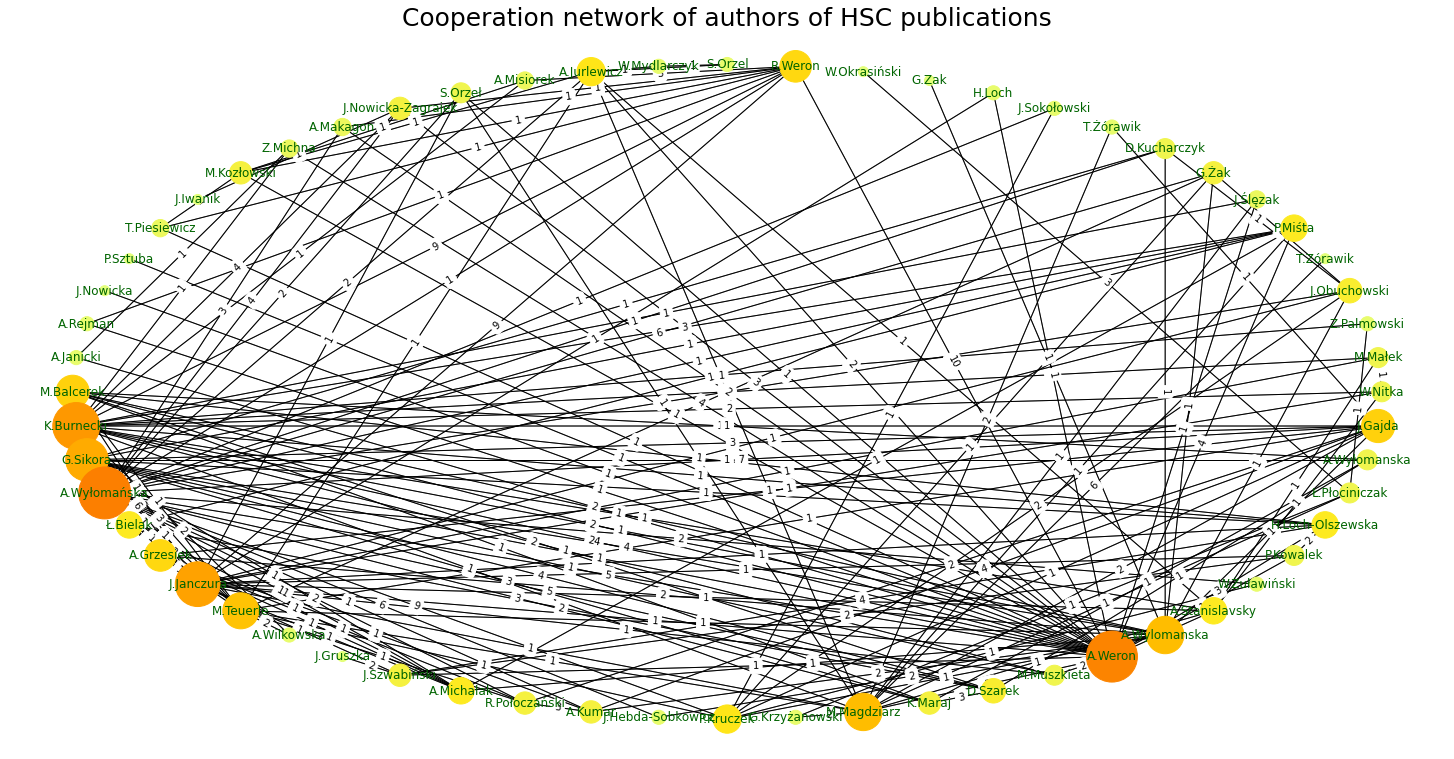

In [14]:
edges_count, links = create_edges(co_authors, hsc_researchers)
G = create_graph(links, edges_count, 'Cooperation network of authors of HSC publications')

## Creating DataFrame

In [15]:
df = pd.DataFrame(articles)
df = df.explode(0).reset_index(drop=True)

hsc = []
for i in range(len(df)):
    if df[0][i] in hsc_researchers:
        hsc.append(True)
    else:
        hsc.append(False)
        
df[1] = df[1].astype(int)
df['HSC'] = hsc
df = df.rename(columns={0: 'Author', 1: 'YearPublished', 2: 'Title', 3: 'NoOfCoAuthors'})

In [16]:
df

,Author,YearPublished,Title,NoOfCoAuthors,HSC
0,M.Balcerek,2021,Discriminating Gaussian processes via quadrati...,4,True
1,K.Burnecki,2021,Discriminating Gaussian processes via quadrati...,4,True
2,G.Sikora,2021,Discriminating Gaussian processes via quadrati...,4,True
3,A.Wyłomańska,2021,Discriminating Gaussian processes via quadrati...,4,True
4,Ł.Bielak,2021,Market risk factors analysis for an internatio...,4,True
...,...,...,...,...,...
1488,W.A.Woyczynski,1995,"Relaxation function in dipolar materials,",3,False
1489,K.Weron,1995,Levy-stable and extreme value distributions in...,4,False
1490,K.Kosmulski,1995,Levy-stable and extreme value distributions in...,4,False
1491,A.Jurlewicz,1995,Levy-stable and extreme value distributions in...,4,True


## What is the number of all articles published?

In [17]:
len(df.groupby(['Title']))

551

## Number of articles published per year?

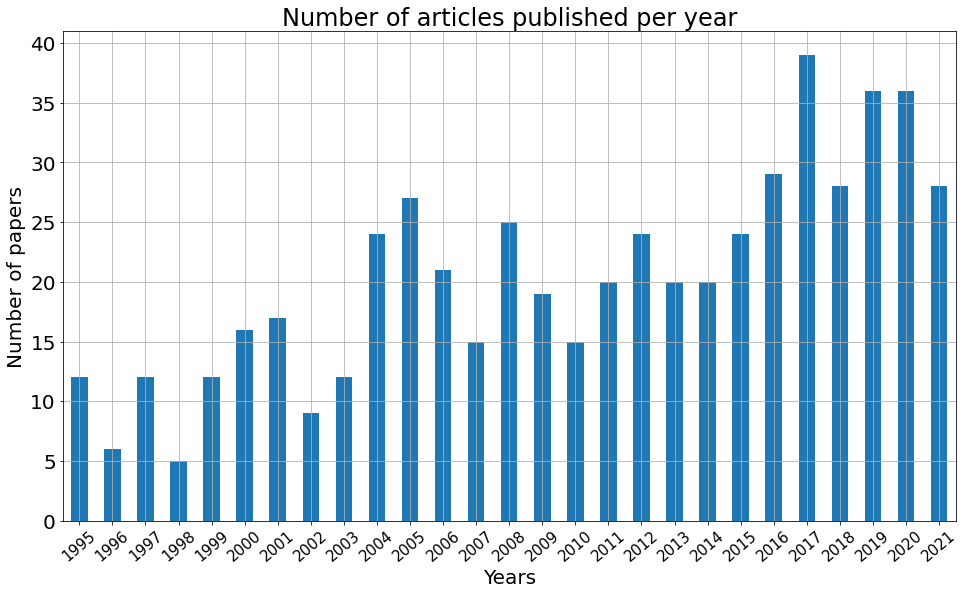

In [18]:
plt.figure(figsize=(16, 9))
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=20)
df.groupby(['Title']).last().groupby('YearPublished').count()['Author'].plot.bar()
plt.title('Number of articles published per year', fontsize=24)
plt.xlabel('Years', fontsize=20)
plt.ylabel('Number of papers', fontsize=20)
plt.xticks(rotation=40)
plt.grid()

##  What is the number of authors?

## What is the number of authors from HSC?

## Cooperation of authors, which has at least two research papers written together

In [19]:
new_dict = {}
for key, value in edges_count.items():
    if value > 2:
        new_dict[key] = value

edges_count = Counter(new_dict) 
        
links = []
for key, value in new_dict.items():
    links.append([key[0], key[1], value])    

In [20]:
K = nx.Graph()
K.add_weighted_edges_from(links)
weights = [K[u][v]['weight'] for u,v in K.edges]
d = dict(K.degree)
low, *_, high = sorted(d.values())
norm = cm.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)

Text(0.5, 1.0, 'Cooperation network of authors')

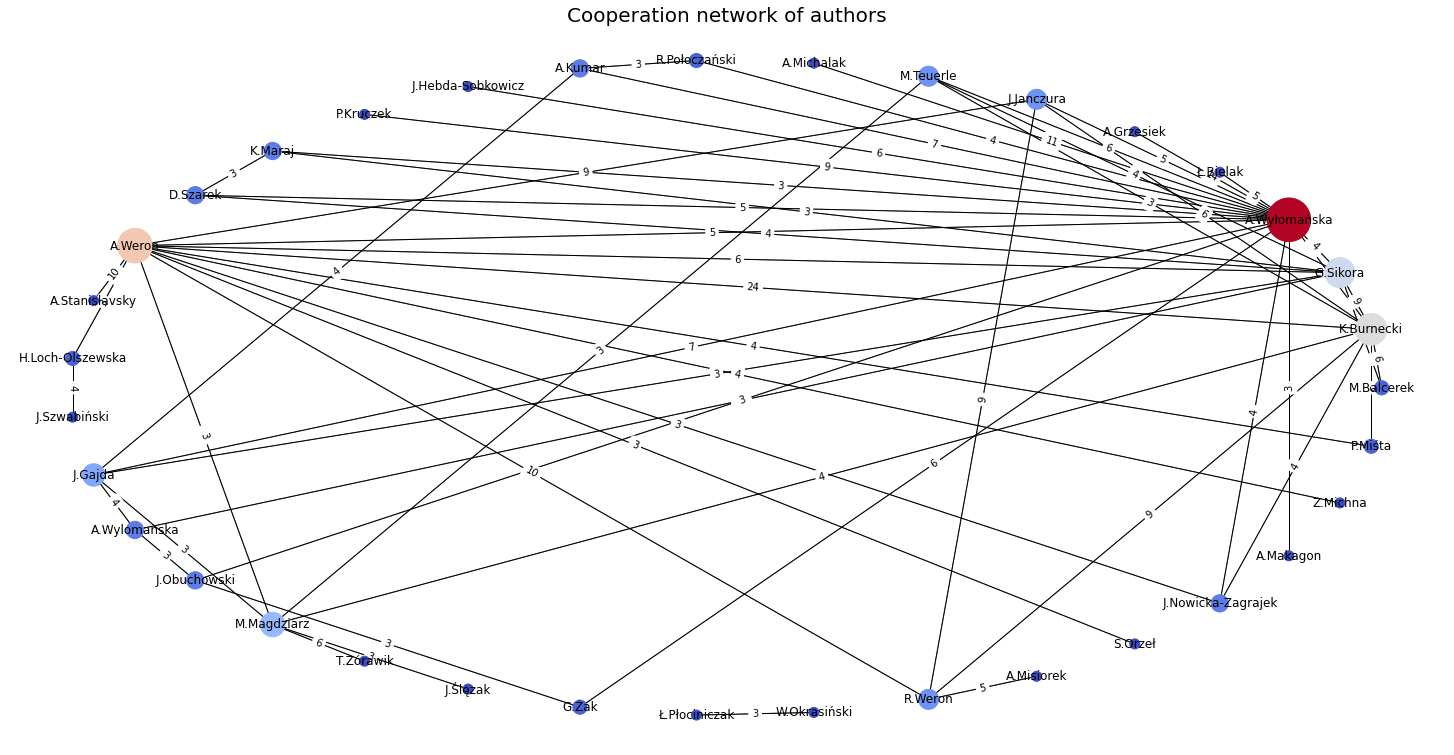

In [21]:
plt.figure(figsize=(20, 10))
pos=nx.circular_layout(K)
nx.draw(K, pos, nodelist=d.keys(), node_size=[v * 100 for v in d.values()], node_color=[mapper.to_rgba(i) for i in d.values()])
nx.draw_networkx_edge_labels(K, pos, edge_labels=edges_count)
nx.draw_networkx_edges(K, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(K, pos)
plt.title('Cooperation network of authors', fontsize=20)

## What pairs cooperate each other the most?

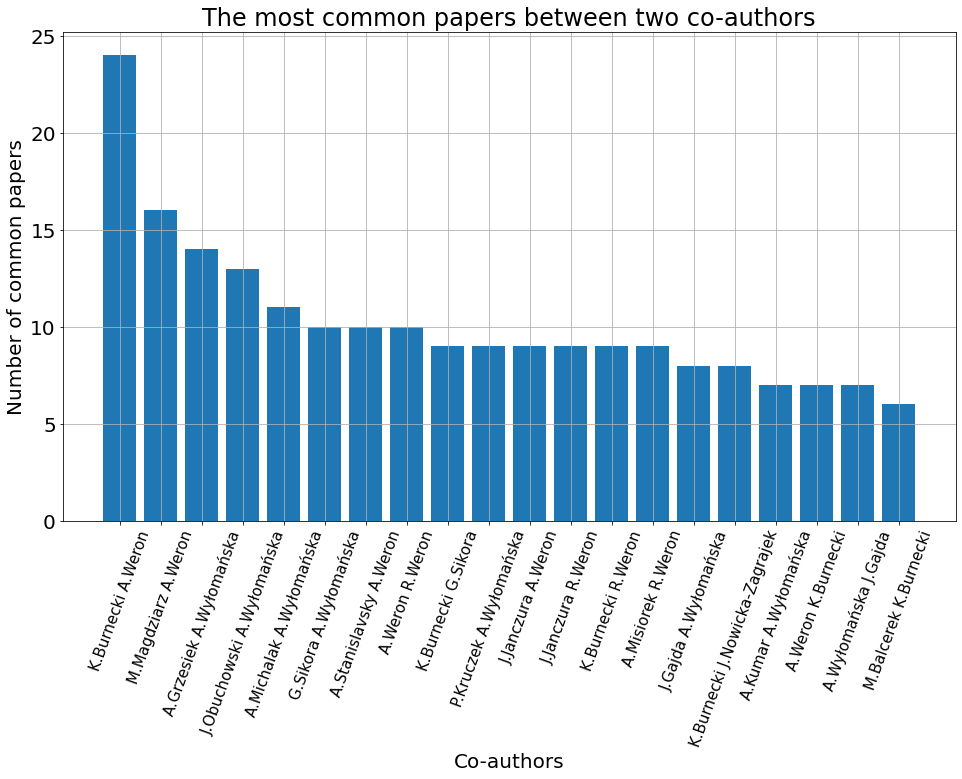

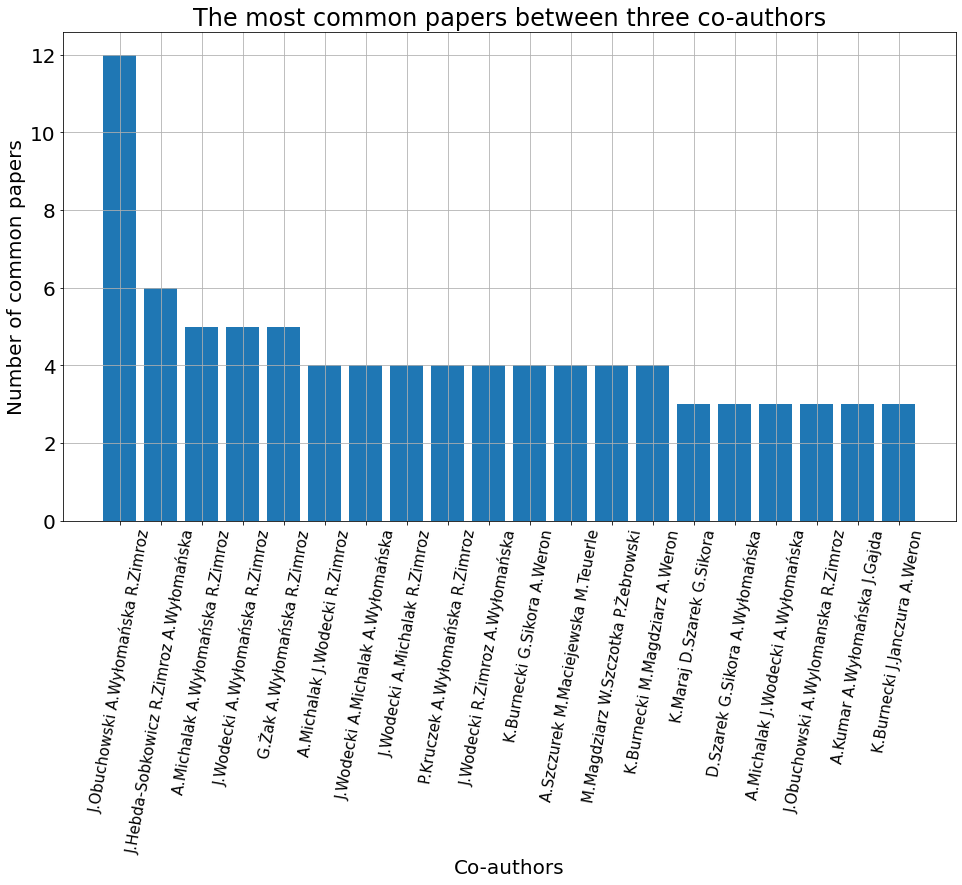

In [22]:
x, y = [], []
for pair in edges_count.most_common()[:20]:
    x.append(pair[0][0] + ' ' + pair[0][1])
    y.append(pair[1])

plt.figure(figsize=(16, 9))
plt.title('The most common papers between two co-authors', fontsize=24)
plt.xlabel('Co-authors', fontsize=20)
plt.ylabel('Number of common papers', fontsize=20)
plt.bar(x, y)
plt.xticks(rotation=70)
plt.grid()

edges_3 = []
for article in co_authors:
    if len(article) > 1:
        for triple in combinations(article, 3):
            edges_3.append(triple)
            
edges_count = Counter(edges_3)

x, y = [], []
for pair in edges_count.most_common()[0:20]:
    x.append(pair[0][0] + ' ' + pair[0][1] + ' ' + pair[0][2])
    y.append(pair[1])


plt.figure(figsize=(16, 9))
plt.title('The most common papers between three co-authors', fontsize=24)
plt.xlabel('Co-authors', fontsize=20)
plt.ylabel('Number of common papers', fontsize=20)
plt.bar(x, y)
plt.xticks(rotation=80)
plt.grid()

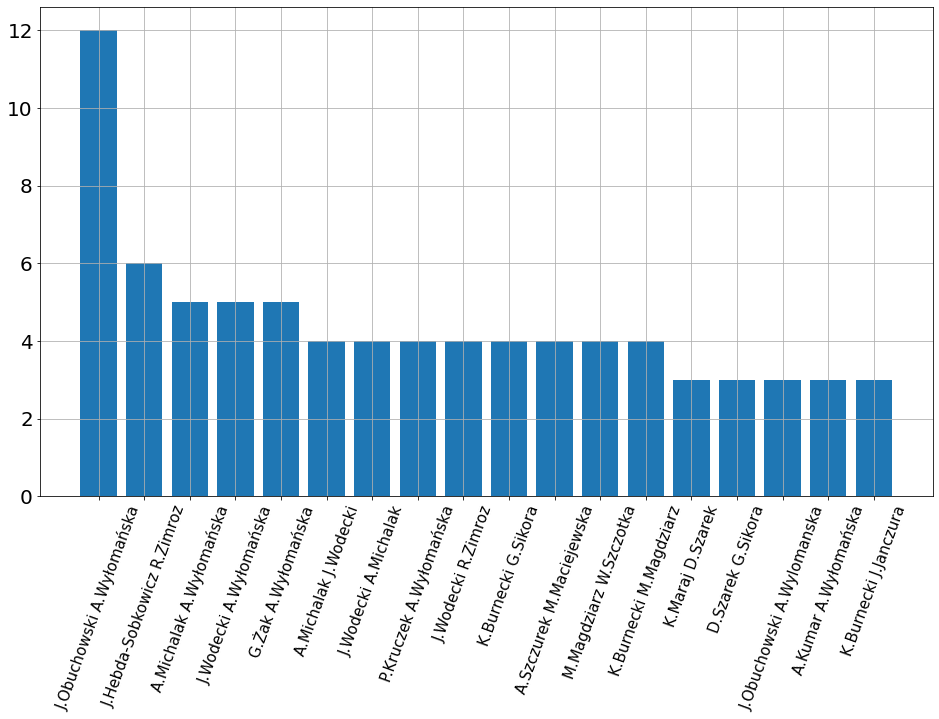

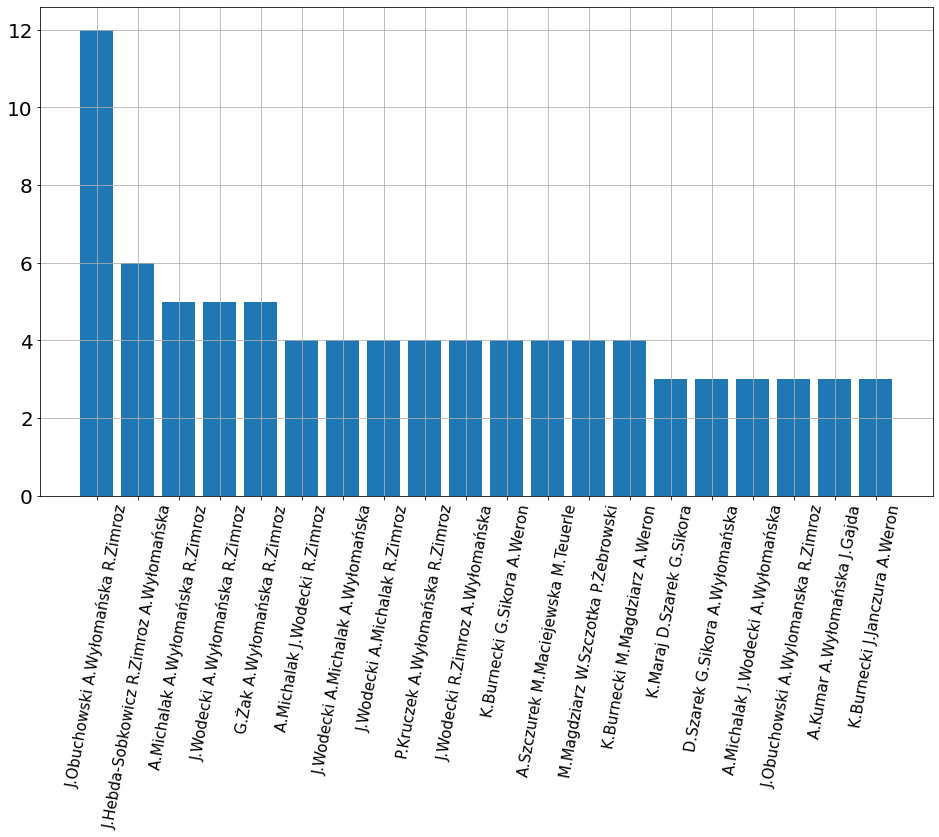

In [23]:
x, y = [], []
for pair in edges_count.most_common()[:20]:
    x.append(pair[0][0] + ' ' + pair[0][1])
    y.append(pair[1])

plt.figure(figsize=(16, 9))
plt.bar(x, y)
plt.xticks(rotation=70)
plt.grid()

edges_3 = []
for article in co_authors:
    if len(article) > 1:
        for triple in combinations(article, 3):
            edges_3.append(triple)
            
edges_count = Counter(edges_3)

x, y = [], []
for pair in edges_count.most_common()[0:20]:
    x.append(pair[0][0] + ' ' + pair[0][1] + ' ' + pair[0][2])
    y.append(pair[1])
    
plt.figure(figsize=(16, 9))
plt.bar(x, y)
plt.xticks(rotation=80)
plt.grid()

## Who published the most articles from Hugo Steinhaus Center?

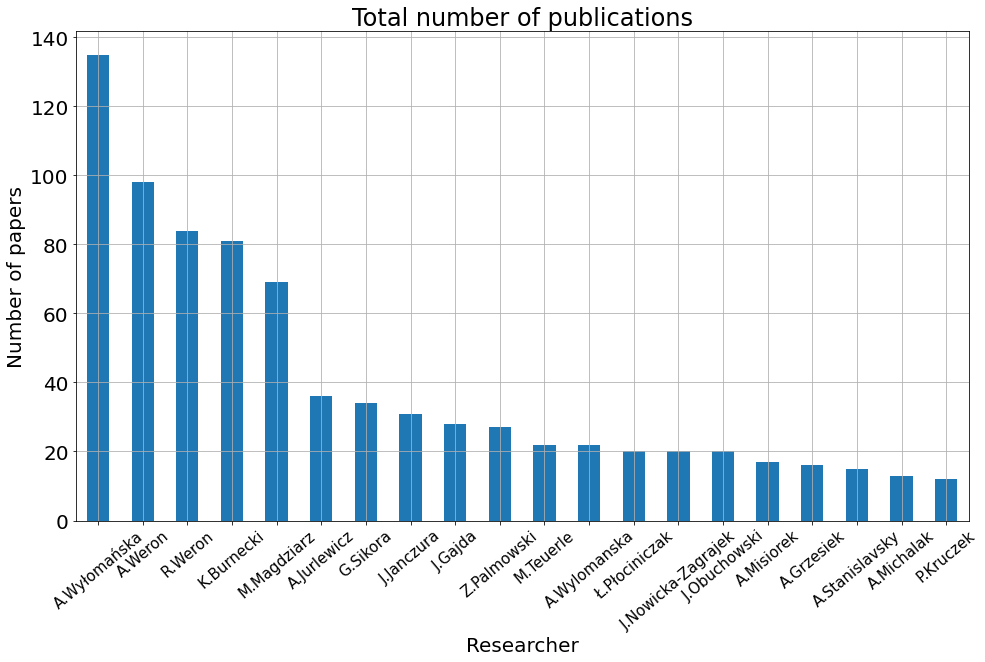

In [24]:
plt.figure(figsize=(16, 9))
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=20)
df[df['HSC'] == True].groupby('Author').sum()['HSC'].sort_values(ascending=False)[0:20].plot.bar()
plt.title('Total number of publications', fontsize=24)
plt.xlabel('Researcher', fontsize=20)
plt.ylabel('Number of papers', fontsize=20)
plt.xticks(rotation=40)
plt.grid()

## What is a proportion of published articles by the most common publishing researcher?

In [25]:
five_authors = df[df['HSC'] == True].groupby('Author').sum()['HSC'].sort_values(ascending=False)[0:5]

In [26]:
five_authors = five_authors.to_dict()

Text(0.5, 1.0, 'Proportion of published articles')

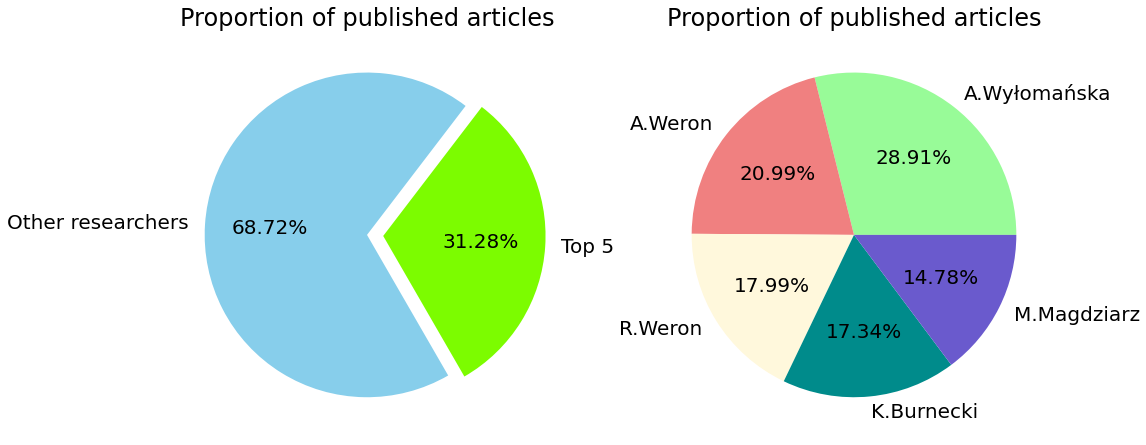

In [27]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 2)

pie_vars = five_authors.keys()
pie_values = five_authors.values()
plt.pie(pie_values, labels=pie_vars, autopct='%1.2f%%', textprops={'fontsize': 20}, colors=['palegreen', 'lightcoral', 'cornsilk', 'darkcyan', 'slateblue'])
plt.title('Proportion of published articles', fontsize=24)

plt.subplot(1, 2, 1)
pie_vars = ['Top 5', 'Other researchers']
pie_values = [sum(five_authors.values()), len(df)-sum(five_authors.values())]
plt.pie(pie_values, labels=pie_vars, explode=(0.1, 0), startangle=300, autopct='%1.2f%%', textprops={'fontsize': 20}, colors=['lawngreen', 'skyblue'])
plt.title('Proportion of published articles', fontsize=24)

## How many articles they publish together?

## Changes in number of publications per year for 5 the most common publicist

In [28]:
list(five_authors.keys())

['A.Wyłomańska', 'A.Weron', 'R.Weron', 'K.Burnecki', 'M.Magdziarz']

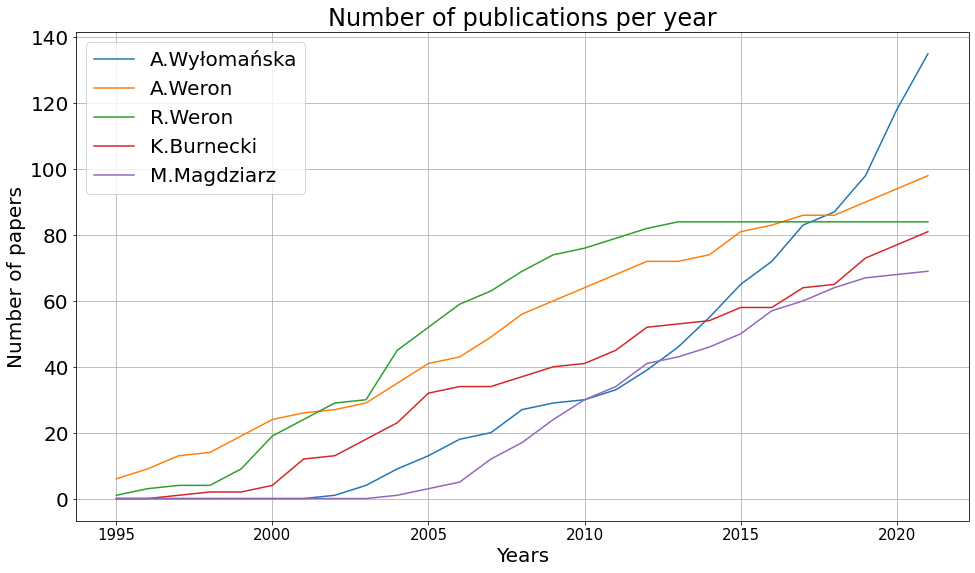

In [29]:
plt.figure(figsize=(16, 9))
for j in range(len(five_authors.keys())):
    x = df[df['Author'] == list(five_authors.keys())[j]].groupby('YearPublished').sum()['HSC'].cumsum().to_dict()
    new_dict = {} 
    for i in range(1995, 2022):
        if i not in list(x.keys()):
            if i-1 > 1995:
                new_dict[i] = new_dict[i-1]
            else:
                new_dict[i] = 0
        else:
            new_dict[i] = x[i]

    plt.plot(new_dict.keys(), new_dict.values(), label=list(five_authors.keys())[j])
    
plt.title('Number of publications per year', fontsize=24)
plt.xlabel('Years', fontsize=20)
plt.ylabel('Number of papers', fontsize=20)
plt.legend(prop={'size':20})
plt.grid()

## What is the average number of co-authors in one publication per year?

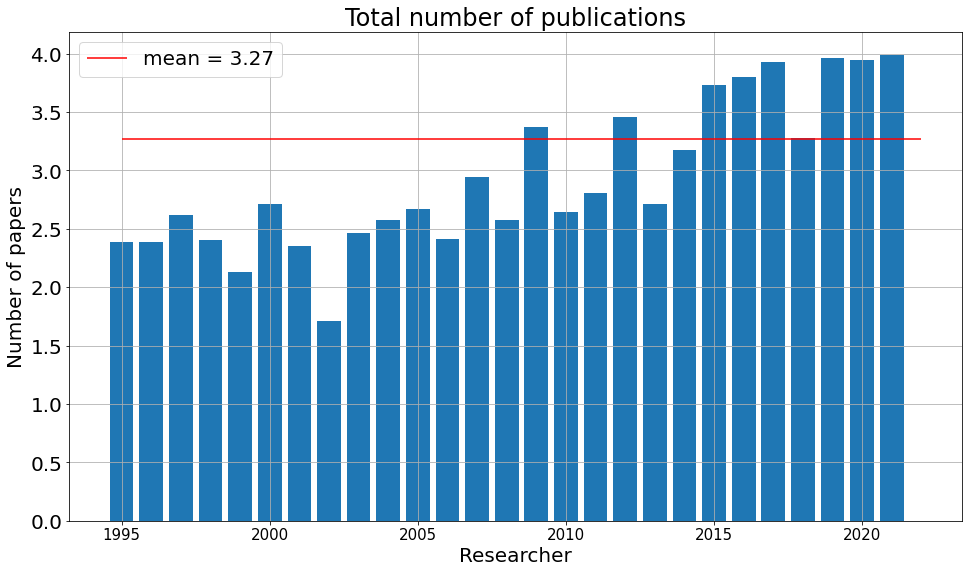

In [30]:
labels = df.groupby(['YearPublished']).mean()['NoOfCoAuthors'].keys()
heights = df.groupby(['YearPublished']).mean()['NoOfCoAuthors'].values
mean = df['NoOfCoAuthors'].mean()

plt.figure(figsize=(16, 9))
plt.hlines(df['NoOfCoAuthors'].mean(), 1995, 2022, color='red', label=f'mean = {round(mean, 2)}')
plt.bar(labels, heights)
plt.title('Total number of publications', fontsize=24)
plt.xlabel('Researcher', fontsize=20)
plt.ylabel('Number of papers', fontsize=20)
plt.legend(prop={'size':20})
plt.grid()

## Distribution of number co-authors for every publication

In [31]:
d = df.groupby(['NoOfCoAuthors']).count()['Author'].sample(frac=1)

Text(0.5, 1.0, 'Proportion of number of co-authors')

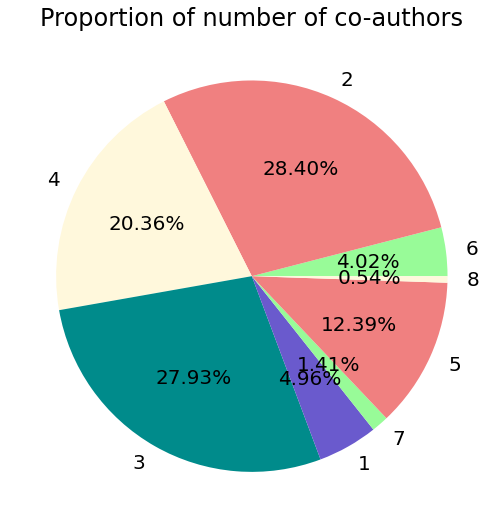

In [32]:
plt.figure(figsize=(16, 9))
pie_vars = d.keys()
pie_values = d.values
plt.pie(pie_values, labels=pie_vars, autopct='%1.2f%%', textprops={'fontsize': 20}, colors=['palegreen', 'lightcoral', 'cornsilk', 'darkcyan', 'slateblue'])
plt.title('Proportion of number of co-authors', fontsize=24)

## What article had 8 co-authors?

In [33]:
df[df['NoOfCoAuthors'] == 8]['Title'].max()[:-2]

'Leveraging large-deviation statistics to decipher the stochastic properties of measured trajectories'

In [34]:
df[df['NoOfCoAuthors'] == 8]

,Author,YearPublished,Title,NoOfCoAuthors,HSC
81,S.Thapa,2021,Leveraging large-deviation statistics to decip...,8,False
82,A.Wyłomańska,2021,Leveraging large-deviation statistics to decip...,8,True
83,G.Sikora,2021,Leveraging large-deviation statistics to decip...,8,True
84,C.E.Wagner,2021,Leveraging large-deviation statistics to decip...,8,False
85,D.Krapf,2021,Leveraging large-deviation statistics to decip...,8,False
86,H.Kantz,2021,Leveraging large-deviation statistics to decip...,8,False
87,A.V.Chechkin,2021,Leveraging large-deviation statistics to decip...,8,False
88,R.Metzler,2021,Leveraging large-deviation statistics to decip...,8,False


## Titles from HSC analysis!!!

## Professor A.Wyłomańska articles analysis

In [35]:
df[df['Author'] == 'A.Wyłomańska']

,Author,YearPublished,Title,NoOfCoAuthors,HSC
3,A.Wyłomańska,2021,Discriminating Gaussian processes via quadrati...,4,True
7,A.Wyłomańska,2021,Market risk factors analysis for an internatio...,4,True
17,A.Wyłomańska,2021,How to describe the linear dependence for heav...,3,True
21,A.Wyłomańska,2021,Moment-based estimation technique for paramete...,4,True
23,A.Wyłomańska,2021,Asymptotics of alternative dependence measures...,2,True
...,...,...,...,...,...
1273,A.Wyłomańska,2004,"On ARMA(1,q) Models with Bounded and Periodica...",2,True
1287,A.Wyłomańska,2003,"Modele gry producentów na giełdzie energii,",2,True
1289,A.Wyłomańska,2003,Rownowaga nasha w grach niekooperacyjnych na r...,2,True
1309,A.Wyłomańska,2003,Analiza porównawcza modelowania ceny energii e...,2,True


In [36]:
titles = list(df[df['Author'] == 'A.Wyłomańska']['Title'].values)

## Sentimental titles analysis of articles which Prof. A.Wyłomańska took part 

In [37]:
eng_stopwords = stopwords.words("english")
Tokenizer = RegexpTokenizer(r"[A-Za-z0-9-]+")

In [38]:
titles

['Discriminating Gaussian processes via quadratic form statistics, ',
 'Market risk factors analysis for an international mining company. Multi-dimensional, heavy-tailed-based modelling, ',
 'How to describe the linear dependence for heavy-tailed distributed data, ',
 'Moment-based estimation technique for parameters of general inverse subordinator, ',
 'Asymptotics of alternative dependence measures for two-dimensional alpha−stable AR(1) model, ',
 'A Method for Structure Breaking Point Detection in Engine Oil Pressure Data, ',
 'Alternative Measures of Dependence for Cyclic Behaviour Identification in the Signal with Impulsive Noise—Application to the Local Damage Detection, ',
 'Generalized Spectral Coherence for cyclostationary signals with alpha−stable distribution, ',
 'Empirical anomaly measure for finite-variance processes, ',
 'Time averaged mean squared displacements ratio test for Gaussian processes with unknown diffusion coefficient, ',
 'Time-averaged statistics-based meth

In [39]:
def cleaning_text(titles):
    cleaned_titles = []
    wl=WordNetLemmatizer()
    for title in titles:
        title = title.lower()
        title = Tokenizer.tokenize(title)
        title = [word for word in title if word not in eng_stopwords]
        title = [word for word in title if not word.isnumeric()]

        cleaned_titles.append(title)

    cleaned_titles_combined = [word for sublist in cleaned_titles for word in sublist]
    
    return cleaned_titles_combined

In [40]:
def find_the_most_common_words(comments, limit=15):
    x = Counter(comments).most_common()[:limit]  
    words = list(zip(*x))[0]
    occurrences = list(zip(*x))[1]
    
    return words, occurrences

In [41]:
cleaned_titles = cleaning_text(titles)

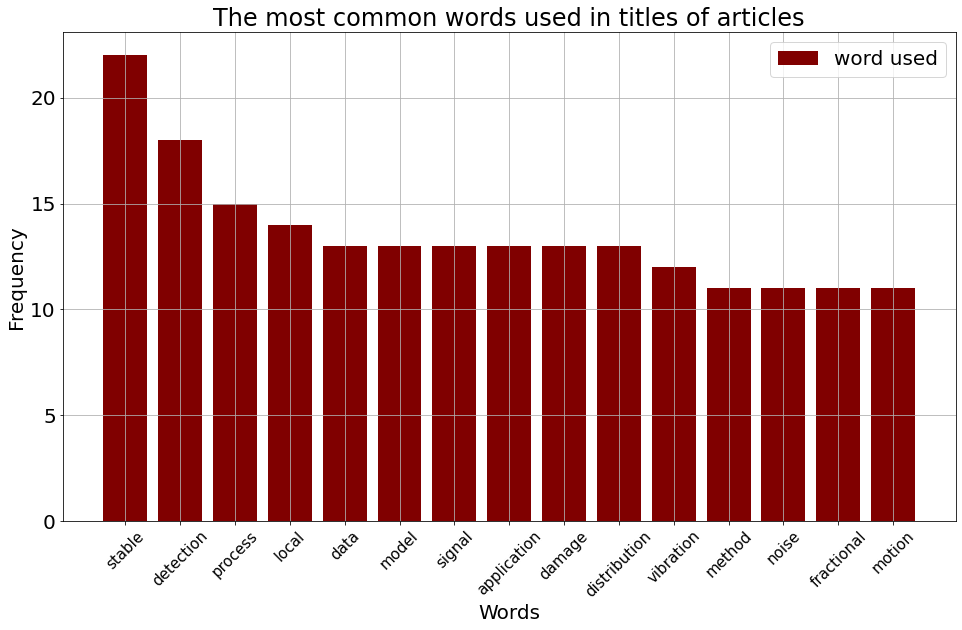

In [42]:
words, occurrences = find_the_most_common_words(cleaned_titles, limit=15)
plt.figure(figsize=(16, 9))
plt.title('The most common words used in titles of articles', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='maroon')
plt.legend(['word used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

In [43]:
def finding_noun_phrases(titles):
    noun_phrases_titles = []
    cleaned_titles = []
    wl=WordNetLemmatizer()
    for title in titles:
        title = title.lower()
        title = Tokenizer.tokenize(title)
        title = [word for word in title if word not in eng_stopwords]
        title = [word for word in title if len(word)>2] 
        title = [word for word in title if not word.isnumeric()]
        title = " ".join(title)
        title = TextBlob(title)
        title = title.noun_phrases   
        noun_phrases_titles.append(title)

    noun_phrases_titles_combined = [word for sublist in noun_phrases_titles for word in sublist]
    
    return noun_phrases_titles_combined

In [44]:
def find_the_most_common_noun_phrases(titles, limit=15):
    x = Counter(titles).most_common()[:limit] 
    x = [phrase for phrase in x if phrase[0] != 'gon na']
    x = [phrase for phrase in x if len(phrase[0].split(' '))==2]
    words = list(zip(*x))[0]
    occurrences = list(zip(*x))[1]
    
    return words, occurrences

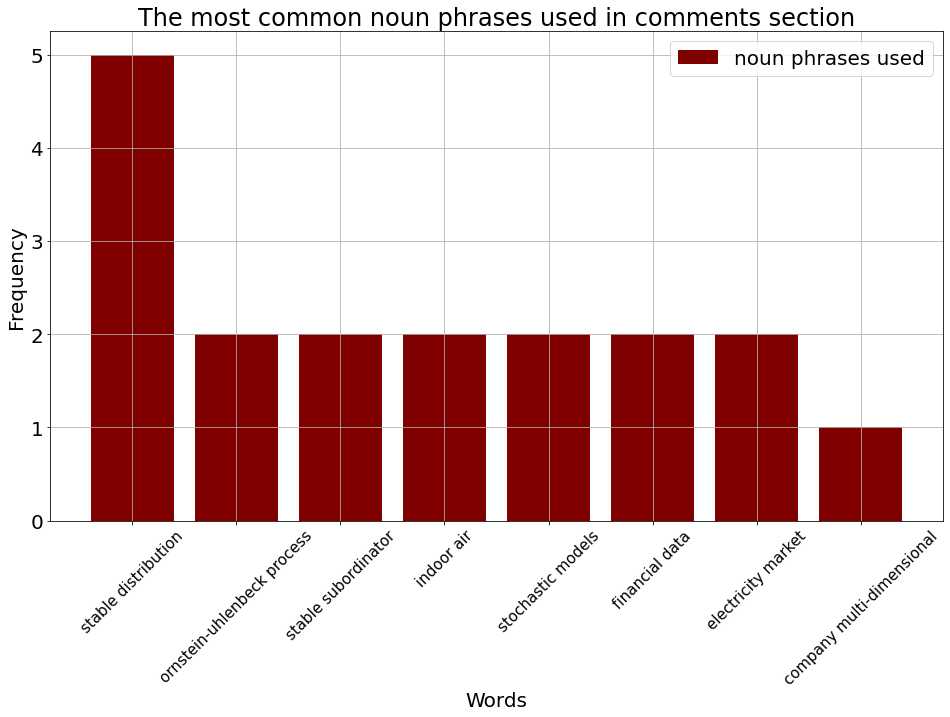

In [45]:
words, occurrences = find_the_most_common_noun_phrases(finding_noun_phrases(titles))
plt.figure(figsize=(16, 9))
plt.title('The most common noun phrases used in comments section', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='maroon')
plt.legend(['noun phrases used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

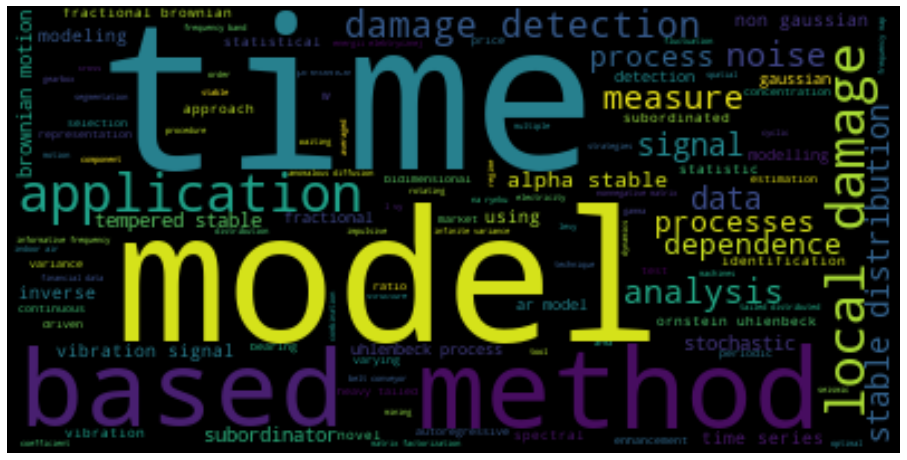

In [46]:
wordcloud = WordCloud(stopwords=eng_stopwords).generate(" ".join(cleaned_titles))
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
analyser = SentimentIntensityAnalyzer()

In [48]:
negative, neutral, positive, compound = [], [], [], []
for title in titles:
    negative.append(analyser.polarity_scores(title)['neg'])
    neutral.append(analyser.polarity_scores(title)['neu'])
    positive.append(analyser.polarity_scores(title)['pos'])
    compound.append(analyser.polarity_scores(title)['compound'])

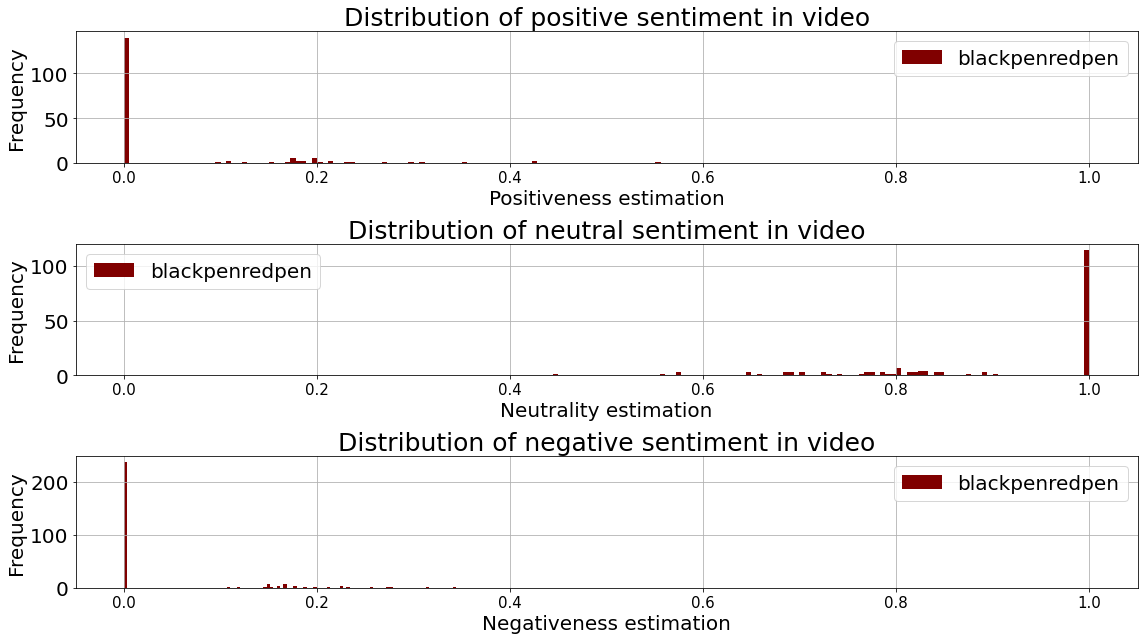

In [49]:
plt.figure(figsize=(16, 9))
plt.subplot(3, 1, 1)
plt.title('Distribution of positive sentiment in video', fontsize=25)
plt.xlabel('Positiveness estimation', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.hist(positive, bins=100, density=True, color='maroon')
plt.grid()
plt.xlim([-0.05, 1.05])
plt.legend(['blackpenredpen'], prop={'size': 20})

plt.subplot(3, 1, 2)
plt.title('Distribution of neutral sentiment in video', fontsize=25)
plt.xlabel('Neutrality estimation', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.hist(neutral, bins=100, density=True, color='maroon')
plt.grid()
plt.xlim([-0.05, 1.05])
plt.legend(['blackpenredpen'], prop={'size': 20})

plt.subplot(3, 1, 3)
plt.title('Distribution of negative sentiment in video', fontsize=25)
plt.xlabel('Negativeness estimation', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.hist(negative, bins=100, density=True, color='maroon')
plt.grid()
plt.xlim([-0.05, 1.05])
plt.legend(['blackpenredpen'], prop={'size': 20})


plt.tight_layout()

Text(0.5, 1.0, 'Sentiment analysis')

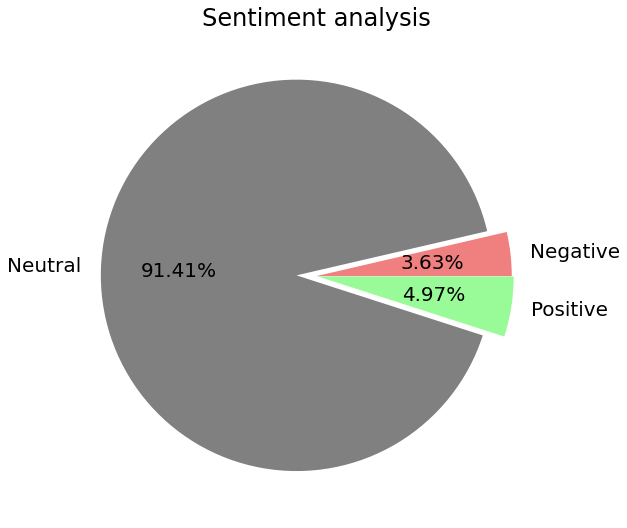

In [50]:
plt.figure(figsize=(16, 9))
pie_vars = ['Negative', 'Neutral', 'Positive']
pie_values = [[sum(negative), sum(positive)]]
plt.pie([sum(negative), sum(neutral), sum(positive)], explode=(0, 0.1, 0.01), labels=pie_vars,autopct='%1.2f%%', textprops={'fontsize': 20}, colors=['lightcoral', 'grey', 'palegreen'])
plt.title('Sentiment analysis', fontsize=24)